# LDE Lab 2: Spreading on Networks

AIM:

- Create two networks of size N = 1000 and similar degree:
    - A Erdös and Rényi random graph 
    - A Barabasi-Albert Scale-free network   

- Adapt the SIR and SIS dynamics to include the network structure
- Write a code that iterates over values of beta and create the epidemic diagram for the two networks




In [2]:
import random
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

N = int(1e3); p = 0.5
beta = 0.001 # infection probability
mu = 0.2 # recovery probability

In [17]:
# This is needed for a rescale of the net:totcases wrt to mf:totcase

def rescale_wrt_ymax(ls):
      ls = np.array(ls)
      max_y = np.max(ls)
      print("inner_max", max_y)
      return list(ls/max_y)

def list_replace(lst, old=0, new=1):
    """replace list elements (inplace)"""
    lst = list(lst)
    i = -1
    try:
        while 1:
            i = lst.index(old, i + 1)
            lst[i] = new
    except:
        pass
    return lst

mean = [1.,2,3,4,5,6,7]
print(mean, "then", [mean[i] for i in range(len(mean)) if list(map(lambda x: x > 4, mean))[i]])
print( list_replace(mean, 1, 4))

ls = np.array([[1,2,3,4,5],[1,1,1,1,10,11]]); N = 5
print(np.max(ls),rescale_wrt_ymax(ls))
#print(max(ls, key = lambda x: x[-1])[-1])
ls = [[x/N for x in el] for el in ls]

[1, 2, 3, 4, 5, 6, 7] then [5, 6, 7]
[1, 2, 3, 4, 5, 6, 7]
inner_max [1, 2, 3, 4, 5]


<ipython-input-17-cec4dd507eaa>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ls = np.array([[1,2,3,4,5],[1,1,1,1,10,11]]); N = 5


ValueError: operands could not be broadcast together with shapes (2,) (5,) 

# SIR dynamics

In [3]:
def sir(G, mf = False, beta = 1e-3, mu = 0.05, seed = False, start_inf = 10):
  #this is the regular sir
  'If mf == False, the neighbors are not fixed;' 
  'If mf == True, std mf by choosing @ rnd the num of neighbors'
  print("mu, beta", mu, beta)

  import random
  #here's the modifications of the "test_ver1"
  'Number of nodes in the graph'
  N, D, _ = N_D_std_D(G)

  'Label the idnividual wrt to the # of the node'
  node_labels = G.nodes()  
  fr_stinf = start_inf/N

  
  'Currently infected idnividuals and the future infected and recovered' 
  susceptible = [1-fr_stinf]
  prevalence = [fr_stinf]
  recovered = [0]
  totcases = [fr_stinf]

  inf_list = [] #infected node list @ each t

  dni = [0] #it was dni = [] # = len(inf_list)/N, i.e. frac of daily infected for every t
  dni_totcases = [fr_stinf]
  dni_susceptible = [1-fr_stinf]

  pos_dni = [] #arr to computer Std(daily_new_inf(t)) for daily_new_inf(t)!=0

  'Initial Codnitions'
  current_state = ['S' for i in node_labels] 
  future_state = ['S' for i in node_labels]
  
  if seed: 
    random.seed(0)

  'Selects the seed of the disease'
  inf_list = random.sample(node_labels, start_inf)  #without replacement, i.e. not duplicates
  if rhu(D,0)-1 <= 0 and mf: #too slow for D = 1
    inf_list = []
  for seed in inf_list:
    current_state[seed] = 'I'
    future_state[seed] = 'I'

  'initilize dni (new daily infected) and recovered list'
  'we dont track infected'

  'start and continue whenever there s 1 infected'
  while(len(inf_list)>0):        
    daily_new_inf = 0
    'Infection Phase: inf_list = prev_time infecteds'
    'each infected tries to infect all of the neighbors'
    for i in inf_list:
        'Select the neighbors of the infected node'
        if not mf: tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
        if mf: 
          ls = list(range(N)); ls.remove(i)
          tests = random.sample(ls, k = int(rhu(D))) #spread very fast since multiple infected center
        tests = [int(x) for x in tests] #convert 35.0 into int
        for j in tests:
          if current_state[j] == 'S' and future_state[j] == 'S' and random.random() < beta:
            future_state[j] = 'I'; daily_new_inf += 1
    
    #"+" to join lists
    if daily_new_inf != 0: pos_dni = pos_dni+[daily_new_inf]

    'Recovery Phase: only the prev inf nodes (=inf_list) recovers with probability mu'
    'not the new infected'    
    'This part is important in the OrderPar since diminishes the inf_list # that is in the "while-loop"'    
    for i in inf_list:
      if random.random() < mu:
          future_state[i] = 'R'
      else:
          future_state[i] = 'I'
    
    'Time update: once infections and recovery ended, we move to the next time-step'
    'The future state becomes the current one'
    current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
    
    'Updates inf_list with the currently fraction of inf/rec and save lenS to avg_R' 

    #IDEA: this is = to take the index on "current_state"
    inf_list = [i for i, x in enumerate(current_state) if x == 'I']
    rec_list = [i for i, x in enumerate(current_state) if x == 'R']

    'Saves the fraction of new daily infected (dni) and recovered in the current time-step'
    prevalence.append(len(inf_list)/float(N))
    recovered.append(len(rec_list)/float(N))
    susceptible.append(1-prevalence[-1]-recovered[-1])

    dni.append(daily_new_inf/float(N))        
    dni_totcases.append(dni_totcases[-1]+daily_new_inf/float(N))            
    totcases.append(totcases[-1]+prevalence[-1]-prevalence[-2]+recovered[-1]-recovered[-2])
    dni_susceptible.append(1-dni_totcases[-1])

  
  #print("End idx_cl %s round"%idx_cl)
  
  N, D, _ = N_D_std_D(G)
  if not mf:
    D2 = sum([j**2 for _,j in G.degree()]) / N
    Rc_net = D**2/(D2-D)
  if mf: 
    Rc_net = 1/(1-D**(-1))
  
  R0 = beta*D/mu
  RcR0 = Rc_net / R0
  p_c = 1 - RcR0
  dni_totcases = np.array(dni_totcases)#[1-x for x in avg_traj[idx_cl]]
  t_c = 0
  flag = True
  for i in np.arange(len(dni_totcases)-1):
    if dni_totcases[i] <= p_c <= dni_totcases[i+1] and flag:
      print("limit", RcR0, p_c)
      y1 = dni_totcases[i+1]; x1 = np.where(dni_totcases == dni_totcases[i+1])[0][0]
      dy = y1 - dni_totcases[i]; dt = 1
      m = dy/dt
      t_c =  1/m * (p_c - y1) + x1
      flag = False
      #t_c = t_c[0][0]
      print(
        "\n dni_totalcases[i], yc, dni[i+1],x1, np.where, tc, mu, beta",
        dni_totcases[i],p_c, dni_totcases[i+1], x1, np.where(dni_totcases == dni_totcases[i])[0][0], t_c, mu, beta)
      print("End of t_c")

  '''
  p_c = 1 - Rc_net / R0
  dni_totcases = np.array(dni_totcases)#[1-x for x in avg_traj[idx_cl]]
  flag = True
  for i in np.arange(len(dni_totcases)-1):
    if flag:
      #print(dni_totcases[-2], p_c, dni_totcases[-1])
      if dni_totcases[i] <= p_c <= dni_totcases[i+1]:
          print("limit", Rc_net / R0, p_c)
          y1 = dni_totcases[i+1]; x1 = np.where(dni_totcases == dni_totcases[i+1])[0][0]
          dy = y1 - dni_totcases[i]; dt = 1
          m = dy/dt
          t_c =  1/m * (p_c - y1) + x1
          #t_c = t_c[0][0]
          flag = False
          print(
            "\n dni_[i], yc, dni[i+1],x1, np.where, tc, mu, beta",
            dni_totcases[i],p_c, dni_totcases[i+1], x1, np.where(dni_totcases == dni_totcases[i])[0][0], t_c, mu, beta)
          print("End of t_c")
      else: t_c = 0
  '''
  'Order Parameter (op) = Std(Avg_dni(t)) s.t. dni(t)!=0 as a func of D'
  op = False
  if not mf and op:
    ddof = 0
    if len(pos_dni) > 1: ddof = 1
    if pos_dni == []: pos_dni = [0]
    oneit_avg_dni = np.mean(pos_dni)
    'op = std_dni'
    op = np.std( pos_dni, ddof = ddof )
    if len(pos_dni) > 1:
      if len([x for x in pos_dni if x == 0]) > 0: 
        raise Exception("Error There's 0 dni: dni, arr_daily, std", daily_new_inf, pos_dni, op)

    'R0 is not a good estimates of the epidemic. Try with its average'
    'oneit_avg_R is the mean over the time of 1 sir. Then, avg over-all iterations'
    'Then, compute std_avg_R'
    degrees = [j for _,j in G.degree()]
    D = np.mean(degrees)
    #print("R0, b,m,D", beta*D/mu, beta, mu, D)
    c = beta*D/(mu*dni_susceptible[0])
    oneit_avg_R = c*np.mean(dni_susceptible)
    ddof = 0
    if len(dni_susceptible) > 1: ddof = 1
    std_oneit_avg_R = c*np.std(dni_susceptible, ddof = 1)
    #print("num_su[0], np.sum(dni_susceptible), len(prev), oneit_avg_R2", \
    #  dni_susceptible[0],np.sum(dni_susceptible), len(dni), oneit_avg_R)

    #return oneit_avg_R, std_oneit_avg_R, oneit_avg_dni, op, dni, dni_totcases
    return oneit_avg_dni, op, dni, dni_totcases

  return susceptible, prevalence, recovered, dni, totcases, dni_totcases, dni_susceptible, t_c, p_c, Rc_net, D

In [4]:
def rhu(n, decimals=1, integer = False): #round_half_up
    import math
    multiplier = 10 ** decimals
    res = math.floor(n*multiplier + 0.5) / multiplier
    if integer: return int(res)
    return res

def N_D_std_D(G):
  degrees = np.asarray([j for i,j in G.degree()])
  return G.number_of_nodes(), np.mean(degrees), np.std(degrees, ddof = 1)


#Set the plot parameters
def plot_params(ax1, plt_title):
  #plt.figure(figsize = (15,8))
  ax1.set_xlabel('Time steps', fontsize = 30, labelpad = 20)
  ax1.set_ylabel('Indivs/N', fontsize = 30, labelpad = 20)
  ax1.tick_params(axis = "both", labelsize = 20)
  ax1.tick_params(axis = "y", labelcolor = "red")
  ax1.grid(color='grey', linestyle='--', linewidth = 0.5)
  #plt.tick_labels(axis='both', which='major', pad=15)
  plt.subplots_adjust(
    top=0.9,
    bottom=0.15,  #0.088
    left=0.12,
    right=0.92)
  #ax1.set_title(f"{plt_title}", fontsize = 30, pad = 20)
  ax1.xaxis.set_tick_params(direction="in", pad=10)
  ax1.yaxis.set_tick_params(direction="in", pad=10)

def plot_sir(G,beta,mu, fig_name, plt_title):
  import numpy as np
  
  #nx.draw_circular(G, with_labels = True)
  #plt.plot()
  #plt.savefig(f"G_{fig_name}.jpg", format="jpg", dpi=200)

  fig, ax1 = plt.subplots(figsize = (15,8))
  plot_params(ax1, plt_title)
  ax2 = ax1.twinx()
  ax2.yaxis.set_tick_params(direction="in", pad=10)
  ax2.tick_params(axis = "both", labelsize = 20)

  flag = True
  susceptible, prevalence, recovered, \
  dni, totcases, dni_totcases, dni_susceptible, t_c, p_c, Rc_net, D = \
    sir(G, beta = beta, mu = mu)
  print(f"{plt_title} is connected?", nx.is_connected(G))
  t_max = np.argmax(prevalence)
  R_0tmax = ( D * susceptible[t_max] ) * beta/mu
  tp_c = t_c - 1/mu
  print(f"t_c, yc, t'c, R_0tmax for {fig_name}", t_c, p_c, tp_c, R_0tmax, ( D * susceptible[t_max+1] ) * beta/mu
  )

  ax1.plot(susceptible, label = "Susceptible", color = "maroon", marker = "o", mec = "black", lw = 0)
  ax2.plot(prevalence, label = "Infected", color = "blue", marker = "o", lw = 0, mec = "k")
  ax2.plot(recovered[int(1/mu):], label = f"Shifted Rec (in={recovered[int(1/mu)]})", color = "darkgreen", marker = "o", mec = "black", linestyle = "none")

  ax1.plot(dni_susceptible, label = f"DNI Susceptible (fin={rhu(dni_susceptible[-1],3)})", color = "red")
  ax2.plot(dni, label = f"DailyNewInfected", color = "tab:blue")
  ax2.plot(dni_totcases, label = f"DNI Total Cases (fin={rhu(dni_totcases[-1],3)})", color = "green",)# marker = "o", linestyle = "none")

  #minax1, _ = ax1.get_ylim()
  #ax2.set_ylim(minax1, 0.5+dni_totcases[-1])

  #if t_c > 0: plt.axvline(t_c, color = "blue", linestyle = "dotted", label = rf"$t_c = {rhu(t_c)}d \, of \, P(t)$")
  label = f"Crit (tc,Pc) = {rhu(t_c,3), rhu(p_c,3)}"
  if t_c > 0: 
    #plt.axvline(t_c, color = "#003312", linestyle = "dashed", label = r"$t_c$ of P(t)" + f"= {rhu(t_c,3)}d")
    ax2.plot(t_c, p_c, color = "darkgreen", marker = "*", mec = "k", markersize = 20, label = label)
  else: 
    ax2.plot(0, color = "darkgreen", marker = "*", markersize = 0, label = label)

  #if t_max > 0: 
  #  plt.axvline(t_max, color = "midnightblue", linestyle = "dashdot", label = r"$t_{MAX}$" + f"= {t_max}d")
    #if susceptible[t_max] > 0: plt.plot(t_max, susceptible[t_max], color = "maroon", marker = "*", markersize = 20, label = f"Suscep_tmax= {rhu     (susceptible[t_max],3)}")

  plt.title("".join((f"{plt_title}",
                    r" $D_{%s}$: %s" % (N, D),
                    r", $p$",f": {rhu(p,3)}",
                    r", $\mu/ \beta$",f": {rhu(mu/beta,1)}",
                    r", $R_0$",f": {rhu(D*beta/mu,3)}",
                    r", $R_{c-net}$", f": {rhu(Rc_net,3)}",                    
                    ))
            , fontsize = 30, pad = 20)

  #ax1.legend(prop={'size': 15}, loc = "best")
  

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=7, prop={'size': 15},)


  #plt.show()
  path_string = "/home/hal21/MEGAsync/Tour_Physics2.0/Thesis/NetSciThesis/Project/ComplexSpread/LateX/images/Ch_TheEpidModels_Methodology"
  plt.savefig(f"{path_string}/{fig_name}.png", format="png", dpi=200)
  plt.close()


N = int(1e3)
beta = 0.3 # infection probability
mu = 0.25 # recovery probability

# simulate SIR dynamics and obtain prevalence
for p in [0.0015, 0.002]: #really good graph for beta, mu, p, N = 0.1, 0.2, 0.02, 1000
  G=nx.erdos_renyi_graph(N,p)
  plot_sir(G,beta,mu,f"er_graph_p{p}_sir","ER --")

# simulate SIR dynamics and obtain prevalence
G = nx.complete_graph(100) # graph
beta_com, mu_com = 0.01, 0.8
plot_sir(G,beta_com,mu_com,"complete_graph_sir","Mean-Field --")

# simulate SIR dynamics and obtain prevalence
Ds = [2,4,6]; p = 0.3
for D in Ds:
  G=nx.connected_watts_strogatz_graph(N,D,p)
  plot_sir(G,beta,mu,f"D{D}_ws_graph_sir","WS --")

mu, beta 0.25 0.3
ER -- is connected? False
t_c, yc, t'c, R_0tmax for er_graph_p0.0015_sir 0 0.4656699889258028 -4.0 1.695312 1.6860479999999998
mu, beta 0.25 0.3
ER -- is connected? False
t_c, yc, t'c, R_0tmax for er_graph_p0.002_sir 0 0.5881043256997456 -4.0 2.150736 2.1208992
mu, beta 0.8 0.01
limit 0.8163265306122449 0.18367346938775508

 dni_totalcases[i], yc, dni[i+1],x1, np.where, tc, mu, beta 0.17 0.18367346938775508 0.23 2 1 1.2278911564625845 0.8 0.01
End of t_c
Mean-Field -- is connected? True
t_c, yc, t'c, R_0tmax for complete_graph_sir 1.2278911564625845 0.18367346938775508 -0.02210884353741549 1.11375 1.0271249999999998
mu, beta 0.25 0.3
WS -- is connected? True
t_c, yc, t'c, R_0tmax for D2_ws_graph_sir 0 0.33333333333333326 -4.0 2.376 2.3688
mu, beta 0.25 0.3
limit 0.25578064252097404 0.7442193574790259

 dni_totalcases[i], yc, dni[i+1],x1, np.where, tc, mu, beta 0.712 0.7442193574790259 0.7769999999999999 12 11 11.495682422754246 0.25 0.3
End of t_c
WS -- is connected? 

In [5]:
def mfsir(N,beta,mu,K):
    '''
    This functions simulates a SIR process 
    
    Arguments:
    
    1) N: the size of the population
    
    2) beta: per-contact probability to transmit the disease from an infected individual to a susceptible one 
    during a single time step 
    
    3) mu: probability to become recovered during a single time step
    
    4) K: number of contacts per time-step
    
    Output:
    
    a list containing the prevalence during each time step
    
    '''
    
    'Creates the labels for all the individuals'
    node_labels = range(N) 
    
    'Creates an empty list to store currently infected individuals' 
    inf_list = [] 
    
    'Creates an empty list to store the time evolution of the infected' 
    prevalence = []

    'Sets the current and future state to S for all the individuals'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
        
    'Selects the seed of the disease'
    seed = random.choice(node_labels) 

    'Sets the status of the seed to I'
    current_state[seed] = 'I'
    future_state[seed] = 'I'
    
    'Adds the seed to the infected list'
    inf_list.append(seed)
    
   
    'Temporal evolution of the dynamics, runs until there are no infected '
    while(len(inf_list)>0): 
        
        'Infection Phase: each infected picks K individuals at random and tries to infect them'        
        for i in inf_list:
            
            'Select K contacts at random'
            tests = random.choices(node_labels, k = K)

            for j in tests:

                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    
                    if random.random() < beta:
                        
                        'IMPORTANT: the status is checked on the current state but updated in the future state'
                        future_state[j] = 'I'

                    else:
                        
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            
            'Also the recovery takes place in the future state'
            if random.random() < mu:
                
                future_state[i] = 'R'
    
            else:
                 
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy()
       
        'Updates inf_list with the currently infected' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']

        'Saves the fraction of infected in the current time-step'
        prevalence.append(len(inf_list)/float(N))
        
    return prevalence
          

# Epidemic Threshold

In [1]:
def run_sir(G,mu,nruns):
    '''
    This function runs several realizations of the SIR dynamics for a range of values of beta 
    to create the epidemic diagram of a given graph G
    
    Arguments:
    
    G: the network 
    
    mu: recovery probability for the SIR
    
    nruns: the number of realization for each value of beta
    
    '''
    
    'to store the epidemic diagram: the betas and the average fraction of recovered at the end of the dynamics'
    beta_tot = []
    rec_tot = []
       
    'Minimum, Maximum and increase of beta'
    beta_min = 0.0
    beta_max = 0.5
    beta_step = 0.01
    
    'runs for all the values of beta in the range'
    for beta in np.arange(beta_min, beta_max, beta_step):
        
        'to store the value of rec at the end of each run, it will be used to calculate the average'
        rec = []
        
        'runs each realization of the dynamics'
        for run in range(nruns):
            
            
            susc, prev, temp_rec = sir(G, beta, mu)
            
            'since we are interested in the fraction of rec at the end of the dynamics, it only stores the last value'
            rec.append(temp_rec[-1])
        
        'calculate the mean fraction of rec over the nruns'
        rec_tot.append(np.mean(rec))
        beta_tot.append(beta/mu)
        
    
    'returns the epidemic diagram'
    return beta_tot, rec_tot

In [2]:
'Calculate the epidemic diagram for a ER graph'
import networkx as nx
import numpy as np

N = int(1e4); p = 0.001
#beta = 0.2; mu = 0.3
mu = 0.8
G = nx.erdos_renyi_graph(N,p) # graph
#mu = 0.2 # recovery probability
nruns = 30 # number of runs 

epi_diagram_betamu, epi_diagram_rec = run_sir(G, mu, nruns)

NameError: name 'np' is not defined

In [ ]:
'Plots the epidemic diagram'
def plot_func_epidthr(G,mu,fig_name, plt_title):
  import matplotlib.pylab as plt
  plot_params(plt_title)  
  plt.title(f"{plt_title}", fontsize = 30, pad = 20)
  plt.plot(epi_diagram_beta,epi_diagram_rec,'go', label = rf"$r(\infty)$")

  plt.ylabel(rf'Final Recovered/N', fontsize = 30, labelpad = 20)
  plt.xlabel(rf'$\beta/ \mu$', fontsize = 30, labelpad = 20)

  plt.xlim(-0.01,0.4)
  #plt.ylabel('R/N', fontsize = 16)
  #plt.show()
  plt.legend(prop={'size': 18})
  plt.savefig(f"{fig_name}.jpg", format="jpg", dpi=200)
  plt.close()

plot_func_epidthr(G,mu,"ER_Epid_Threshold", "ER Epidemic Threshold")

# SIS dynamics

In [ ]:
def sis(G,beta,mu,t_max):
    '''
    This functions simulates a SIR process 
    
    Arguments:
    
    1) G: the graph on which run the dynamics
    
    2) beta: per-contact probability to transmit the disease from an infected individual to a susceptible one 
    during a single time step 
    
    3) mu: probability to become recovered during a single time step
    
    4) t_max: maximum number of time-steps in the simulation
    
    Output:
    
    a list containing the prevalence during each time step
    
    '''
    'Number of nodes in the graph'
    N=G.number_of_nodes()
    
    'Creates the labels for all the individuals'
    node_labels = G.nodes()
    
    'Creates an empty list to store currently infected individuals' 
    inf_list = [] 
    
    'Creates an empty list to store the time evolution of the infected' 
    prevalence = []

    'Sets the current and future state to S for all the individuals'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
        
    'Selects the seed of the disease'
    seed = random.choice(range(N)) 

    'Sets the status of the seed to I'
    current_state[seed] = 'I'
    future_state[seed] = 'I'
    
    'Adds the seed to the infected list'
    inf_list.append(seed)
    
    
    'Temporal evolution of the dynamics, runs until t_max or there are no infected'
    for t in range(t_max): 
        
        'Infection Phase: each infected picks K individuals at random and tries to infect them'        
        for i in inf_list:
            
            'Select the neighbors of the infected node'
            tests = G.neighbors(i)

            for j in tests:

                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    
                    if random.random() < beta:
                        
                        'IMPORTANT: the status is checked on the current state but updated in the future state'
                        future_state[j] = 'I'

                    else:
                        
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state goes back to S with probability mu'        
        for i in inf_list:
            
            'Also the recovery takes place in the future state'
            if random.random() < mu:
                
                future_state[i] = 'S'
    
            else:
                 
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy()
       
        'Updates inf_list with the currently infected' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        
        'Saves the fraction of infected in the current time-step'
        prevalence.append(len(inf_list)/float(N))
        
        'If there are no more infected ends the dynamics'
        if len(inf_list) == 0:
            break
        
    return prevalence

In [ ]:
G=Gba # graph
beta = 0.6 # infection probability
mu = 1.0 # recovery probability
t_max = 100 # maximum simulation time

# simulate SIS dynamics and obtain prevalence
prevalence = sis(Gba, beta, mu,t_max)

Text(0, 0.5, 'I/N')

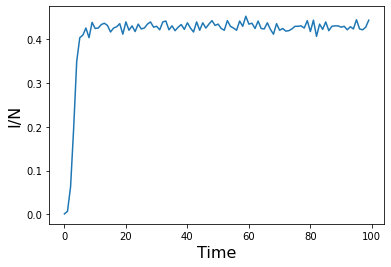

In [ ]:
plt.plot(prevalence)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('I/N', fontsize = 16)

In [ ]:
def run_sis(G,mu,t_max,nruns):
    '''
    This function runs several realizations of the SIS dynamics for a range of values of beta 
    to create the epidemic diagram of a given graph G
    
    Arguments:
    
    G: the network 
    
    mu: recovery probability for the SIR
    
    t_max: the maximum duration of the simulation
    
    nruns: the number of realization for each value of beta
    
    '''
    
    'to store the epidemic diagram: the betas and the average prevalence at the end of the dynamics'
    beta_tot = []
    prev_tot = []
       
    'Minimum, Maximum and increase of beta'
    beta_min = 0.0
    beta_max = 1.0
    beta_step = 0.01
    
    'runs for all the values of beta in the range'
    for beta in np.arange(beta_min, beta_max, beta_step):
        
        'to store the value of prev at the end of each run, it will be used to calculate the average'
        prev = []
    
        'runs each realization of the dynamics'
        for run in range(nruns):
            
            temp_prev = sis(G, beta, mu,t_max)
            
            'since we are interested in the fraction of rec at the end of the dynamics, it only stores the last value'
            'for the SIS it would be better to take the average of the last time steps instead of the last one'
            prev.append(temp_prev[-1])
        
        'calculate the average of the prevalance at the steady state'
        prev_tot.append(np.mean(prev))
        beta_tot.append(beta)
        
    'returns the epidemic diagram'
    return beta_tot, prev_tot

In [ ]:
'Calculates the epidemic diagram for a ER graph'

G=Ger # graph
mu = 0.8 # recovery probability
nruns = 10 # number of runs 
t_max = 30 # maximum simulation time


# simulate SIS dynamics and obtain prevalence
epi_diagram_beta, epi_diagram_prev = run_sis(G, mu, t_max, nruns)


Text(0, 0.5, 'I/N')

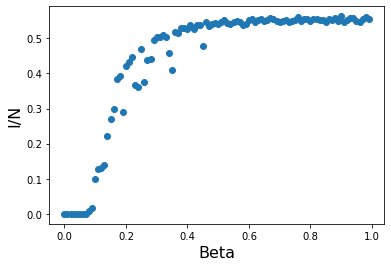

In [ ]:
'Plots the epidemic diagram'

plt.plot(epi_diagram_beta,epi_diagram_prev,'o')
plt.xlabel('Beta', fontsize = 16)
plt.ylabel('I/N', fontsize = 16)